In [1]:
import shap
import numpy as np
import xgboost as xgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pickle


/Users/bkuwahara/Documents/GitHub/shap/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the diabetes dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 3351.001637862091


In [3]:
feature_names = diabetes.feature_names
M = len(feature_names)
c1 = shap.ChainComponent.from_set({0,1}, M, False, "Demographics")
c2 = shap.ChainComponent.from_set({2,3}, M, True, "Vitals")
c3 = shap.ChainComponent.from_set(set(range(4,len(feature_names))), M, False, "Blood Tests")

In [6]:
f = lambda x: model.predict(x)
samples = shap.sample(X_train)
preds = model.predict(X_test)
causal_explainer = shap.GraphKernelExplainer(f, samples, [c1, c2, c3], [[c1, c2], [c2, c3], [c1,c3]], feature_names=feature_names)
baseline_explainer = shap.KernelExplainer(f, samples, feature_names=feature_names)


In [7]:
baseline_explanation = baseline_explainer(X_test[0:20])

100%|██████████| 20/20 [00:02<00:00,  6.98it/s]


In [8]:
causal_explanation = causal_explainer(X_test[0:20,:], samples_per_subset=25)

100%|██████████| 20/20 [01:08<00:00,  3.40s/it]


In [9]:
for explanation in [baseline_explanation, causal_explanation]:
    print(np.abs(explanation.values.sum(axis=1) + explanation.base_values - preds).min()) # these should be close to zero

ValueError: operands could not be broadcast together with shapes (20,) (89,) 

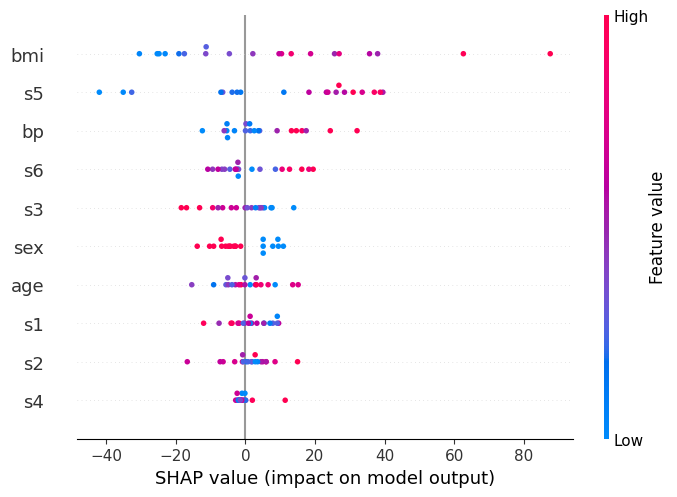

In [10]:
shap.plots.beeswarm(baseline_explanation)

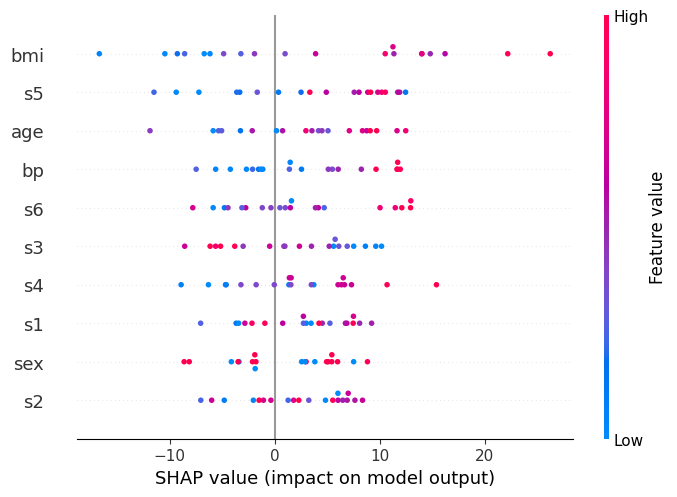

In [11]:
shap.plots.beeswarm(causal_explanation)

In [5]:
e1 = shap.GraphKernelExplainer(f, samples, [c1, c2, c3], [[c1, c2], [c2, c3], [c1,c3]], feature_names=feature_names)
e2 = shap.GraphKernelExplainer(f, samples, [c1, c2, c3], [[c2, c3]], feature_names=feature_names)
e3 = shap.GraphKernelExplainer(f, samples, [c1, c2, c3], [[c2, c1], [c3, c2]], feature_names=feature_names)

In [6]:
explanations = []
for e in [e1, e2, e3]:
    exp = e(X_test[0:20,:], samples_per_subset=25)
    explanations.append(exp)

100%|██████████| 20/20 [00:53<00:00,  2.67s/it]


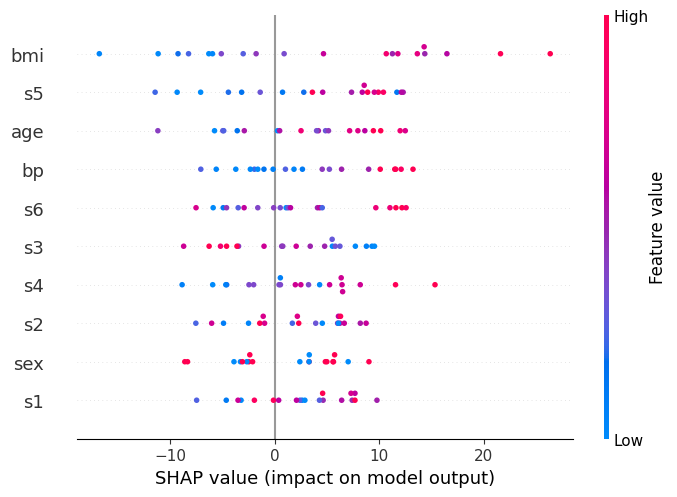

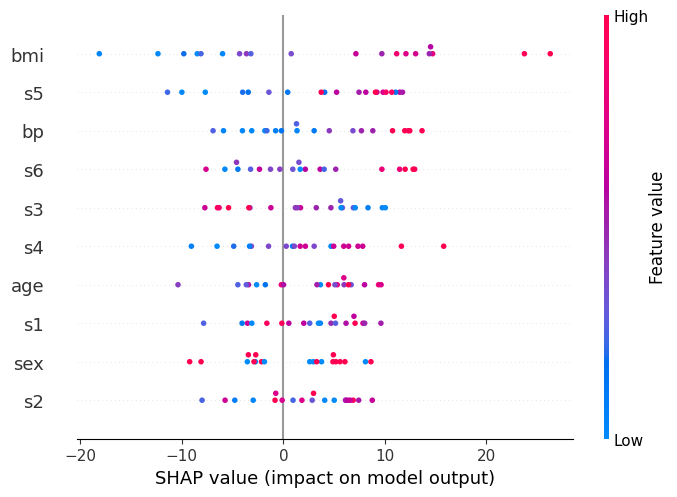

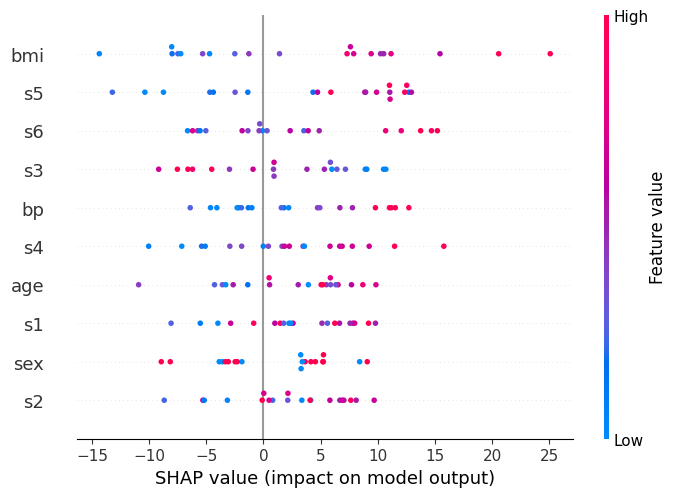

In [7]:
for e in explanations:
    shap.plots.beeswarm(e)

In [16]:
for e in explanations:
    rankings = np.argsort(np.abs(e.values).mean(axis=0))[::-1]
    sorted_feature_names = [feature_names[i] for i in rankings]
    print(sorted_feature_names)

['bmi', 's5', 'age', 'bp', 's6', 's3', 's4', 's2', 'sex', 's1']
['bmi', 's5', 'bp', 's6', 's3', 's4', 'age', 's1', 'sex', 's2']
['bmi', 's5', 's6', 's3', 'bp', 's4', 'age', 's1', 'sex', 's2']


In [18]:
for e in explanations:
    print(np.abs(e.values[:,0]).mean())

6.129160498290775
5.020508532188421
5.033358867957849
